In [1]:
# helper functions
from scipy.misc import imresize
from scipy.signal import convolve2d
from scipy import fftpack

def make_radius_map(Nx,Ny,dx,dy,x0,y0):
    yy,xx = np.meshgrid(np.arange(Nx),np.arange(Nx))
    rr = np.sqrt(((xx-x0)*dx)**2 + ((yy-y0)*dy)**2)
    return rr

def gauss2d(rr,dx,dy,sig):
    g = np.exp(-rr**2/2./sig**2) / (2*np.pi*sig**2)
    g *= dx*dy
    return g

def make_xxyy_map(Nx,Ny,dx,dy,x0,y0):
    yy,xx = np.meshgrid(np.arange(Nx),np.arange(Nx))
    xx = (xx-x0) * dx
    yy  =(yy-y0) * dy
    return xx,yy

def gauss2d_ellipse(xx,yy,dx,dy,sigx,sigy):
    g = np.exp(-xx**2/2./sigx**2)*np.exp(-yy**2/2./sigy**2) / (2*np.pi*sigx*sigy)
    g *= dx*dy
    return g

def rebin_map_coarse(mapin,Nx,Ny):
    '''
    binning Nx,Ny mapin pixel to a large pixel.
    '''
    Nsx,Nsy = mapin.shape
    Nlx = round(Nsx/Nx)
    Nly = round(Nsy/Ny)
    
    rbmap=np.zeros([Nlx,Nly])
    for i in np.arange(Nlx):
        for j in np.arange(Nly):
            rbmap[i,j]=np.mean(mapin[i*Nx:(i+1)*Nx,j*Ny:(j+1)*Ny])

    return rbmap

def get_1D_profile(mapin,dx,dy, logbin=True, nbins = 15, binedges = []):
    rr = make_radius_map(mapin.shape[0],mapin.shape[1],dx,dy,Nsub,Nsub)
    rmin = min(rr[rr>0])
    rmax = max(rr[rr>0])

    if len(binedges)==0:
        if logbin: 
            binedges = np.logspace(np.log10(rmin),np.log10(rmax), nbins+1)
            bins = (binedges[:-1] + binedges[1:]) / 2
            binedges[0] = 0
            binedges[-1] *= 1.01
        else: 
            binedges = np.linspace(np.min(rmin), rmax, nbins+1)
            bins = np.sqrt(binedges[:-1] * binedges[1:])
            binedges[-1] *= 1.01

    else:
        bins = (binedges[:-1] + binedges[1:]) / 2
    
    P1D = np.histogram(rr, bins=binedges, weights=mapin)[0] \
         / np.histogram(rr, bins=binedges)[0]
    
    return P1D,bins

/Users/ytcheng/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:39: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/Users/ytcheng/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:72: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


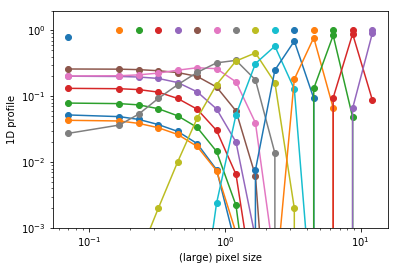

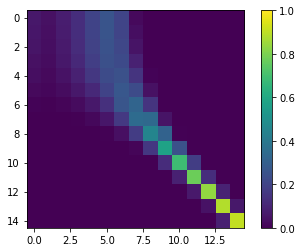

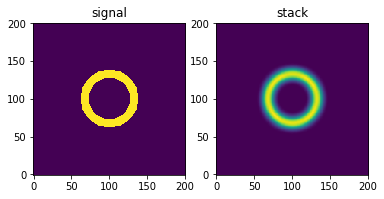

In [2]:
#
scale = 10 # subpixel is 'scale' times smaller than origial pixel
Npix = 10 # the stamp extend Npix pixels in each direction
Nsub = Npix*scale # stacking stamp: (Nsub*2+1)**2 subpixels
sig = 0.5 # w.r.t. large pixel
Nstack = 500 # number of random source stacking

pt_src = np.zeros([2 * Nsub + 1, 2 * Nsub + 1])
pt_src[Nsub, Nsub] = 1

xx,yy = np.meshgrid(np.arange(2 * Nsub + 1), np.arange(2 * Nsub + 1))
xx = abs(xx - Nsub)
yy = abs(yy - Nsub)
psf_pix = (scale - xx)*(scale - yy)
psf_pix[(xx >= scale)] = 0
psf_pix[(yy >= scale)] = 0
psf_pix = psf_pix / np.sum(psf_pix)

rr = make_radius_map(2*Nsub + 1, 2*Nsub + 1, 1./scale, 1./scale, Npix * scale, Npix * scale)
rbinedges = np.logspace(np.log10(0.1),np.log10(np.max(rr)), 16)
rbinedges[0] = 0
rbinedges[-1] *= 1.01

color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']
pix_mkk = np.zeros([len(rbinedges)-1,len(rbinedges)-1])
plt.figure()
for i, (rmin, rmax) in enumerate(zip(rbinedges[:-1],rbinedges[1:])):
    sigmap = np.zeros_like(rr)
    sigmap[(rr < rmax) & (rr > rmin)] = 1
    stack_theory = convolve2d(sigmap, psf_pix, mode='same')
    
    stack = np.zeros([2*Nsub+1,2*Nsub+1])
    src_coord = np.random.uniform(Nsub-0.5, Nsub+scale-1+0.5,[Nstack,2])
    for xsrc,ysrc in src_coord:
        rri = make_radius_map(2*Nsub+scale,2*Nsub+scale,1./scale,1./scale,xsrc,ysrc)
        sigmapi = np.zeros_like(rri)
        sigmapi[(rri < rmax) & (rri > rmin)] = 1
        sigmapi_coarse = rebin_map_coarse(sigmapi,scale,scale)
        psf_fine=imresize(sigmapi_coarse,float(scale),interp='nearest',mode='F')
        stamp = psf_fine[int(round(xsrc)-Nsub):int(round(xsrc)+Nsub+1),\
                         int(round(ysrc)-Nsub):int(round(ysrc)+Nsub+1)]
        stack += stamp/Nstack
    sig1D,_ = get_1D_profile(sigmap,1/scale,1/scale, binedges= rbinedges)
    stack1D,bins = get_1D_profile(stack,1/scale,1/scale, binedges= rbinedges)
    pix_mkk[:,i] = stack1D / sig1D[i]
    plt.plot(bins,sig1D,'o', c = color_list[i%len(color_list)])
    plt.plot(bins,stack1D,'o-',c = color_list[i%len(color_list)])
plt.yscale('log')
plt.xscale('log')
plt.xlabel('(large) pixel size')
plt.ylabel('1D profile')
plt.ylim([1e-3,2e0])
plt.savefig('plots/pixel_mode_coupling', dpi = 200)

plt.figure()
plt.imshow(pix_mkk, vmax = 1, vmin = 0)
plt.colorbar()
plt.savefig('plots/pixel_mode_coupling_mkk', dpi = 200)

rmin = rbinedges[10]
rmax = rbinedges[11]
sigmap = np.zeros_like(rr)
sigmap[(rr < rmax) & (rr > rmin)] = 1
stack_theory = convolve2d(sigmap, psf_pix, mode='same')

stack = np.zeros([2*Nsub+1,2*Nsub+1])
src_coord = np.random.uniform(Nsub-0.5, Nsub+scale-1+0.5,[Nstack,2])
for xsrc,ysrc in src_coord:
    rri = make_radius_map(2*Nsub+scale,2*Nsub+scale,1./scale,1./scale,xsrc,ysrc)
    sigmapi = np.zeros_like(rri)
    sigmapi[(rri < rmax) & (rri > rmin)] = 1
    sigmapi_coarse = rebin_map_coarse(sigmapi,scale,scale)
    psf_fine=imresize(sigmapi_coarse,float(scale),interp='nearest',mode='F')
    stamp = psf_fine[int(round(xsrc)-Nsub):int(round(xsrc)+Nsub+1),\
                     int(round(ysrc)-Nsub):int(round(ysrc)+Nsub+1)]
    stack += stamp/Nstack
    
f, ax = plt.subplots(1,2, figsize=(6,3))
im = ax[0].imshow(sigmap, origin='lower')
ax[0].set_title('signal')
im = ax[1].imshow(stack,origin='lower')
ax[1].set_title('stack')
plt.savefig('plots/pixel_mode_coupling_img', dpi = 200)

rbin 1/15


/Users/ytcheng/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:46: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


rbin 2/15
rbin 3/15
rbin 4/15
rbin 5/15
rbin 6/15
rbin 7/15
rbin 8/15
rbin 9/15
rbin 10/15
rbin 11/15
rbin 12/15
rbin 13/15
rbin 14/15
rbin 15/15


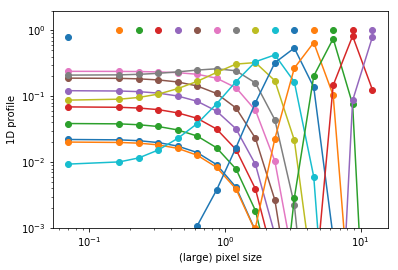

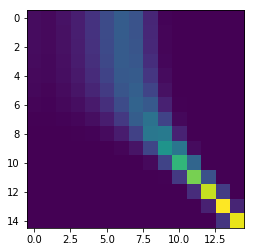

In [42]:
#
scale = 10 # subpixel is 'scale' times smaller than origial pixel
Npix = 10 # the stamp extend Npix pixels in each direction
Nsub = Npix*scale # stacking stamp: (Nsub*2+1)**2 subpixels
sig = 0.5 # w.r.t. large pixel
Nstack = 500 # number of random source stacking

pt_src = np.zeros([2 * Nsub + 1, 2 * Nsub + 1])
pt_src[Nsub, Nsub] = 1

rr = make_radius_map(2*Nsub + 1, 2*Nsub + 1, 1./scale, 1./scale, Npix * scale, Npix * scale)
psf_beam = gauss2d(rr,1./scale,1./scale,sig)

xx,yy = np.meshgrid(np.arange(2 * Nsub + 1), np.arange(2 * Nsub + 1))
xx = abs(xx - Nsub)
yy = abs(yy - Nsub)
psf_pix = (scale - xx)*(scale - yy)
psf_pix[(xx >= scale)] = 0
psf_pix[(yy >= scale)] = 0
psf_pix = psf_pix / np.sum(psf_pix)

rr = make_radius_map(2*Nsub + 1, 2*Nsub + 1, 1./scale, 1./scale, Npix * scale, Npix * scale)
rbinedges = np.logspace(np.log10(0.1),np.log10(np.max(rr)), 16)
rbinedges[0] = 0
rbinedges[-1] *= 1.01

color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']
pix_mkk = np.zeros([len(rbinedges)-1,len(rbinedges)-1])
plt.figure()
for i, (rmin, rmax) in enumerate(zip(rbinedges[:-1],rbinedges[1:])):
    print('rbin %d/%d'%(i+1,len(rbinedges)-1))
    sigmap = np.zeros_like(rr)
    sigmap[(rr < rmax) & (rr > rmin)] = 1
    stack_theory = convolve2d(sigmap, psf_pix, mode='same')
    
    stack = np.zeros([2*Nsub+1,2*Nsub+1])
    src_coord = np.random.uniform(Nsub-0.5, Nsub+scale-1+0.5,[Nstack,2])
    
    count=0
    for xsrc,ysrc in src_coord:
        rri = make_radius_map(2*Nsub+scale,2*Nsub+scale,1./scale,1./scale,xsrc,ysrc)
        sigmapi = np.zeros_like(rri)
        sigmapi[(rri < rmax) & (rri > rmin)] = 1
        sigmapi = convolve2d(sigmapi, psf_beam, mode='same')
        sigmapi_coarse = rebin_map_coarse(sigmapi,scale,scale)
        psf_fine=imresize(sigmapi_coarse,float(scale),interp='nearest',mode='F')
        stamp = psf_fine[int(round(xsrc)-Nsub):int(round(xsrc)+Nsub+1),\
                         int(round(ysrc)-Nsub):int(round(ysrc)+Nsub+1)]
        stack += stamp/Nstack
    sig1D,_ = get_1D_profile(sigmap,1/scale,1/scale, binedges= rbinedges)
    stack1D,bins = get_1D_profile(stack,1/scale,1/scale, binedges= rbinedges)
    pix_mkk[:,i] = stack1D / sig1D[i]
    plt.plot(bins,sig1D,'o', c = color_list[i%len(color_list)])
    plt.plot(bins,stack1D,'o-',c = color_list[i%len(color_list)])
plt.yscale('log')
plt.xscale('log')
plt.xlabel('(large) pixel size')
plt.ylabel('1D profile')
plt.ylim([1e-3,2e0])
plt.savefig('plots/pixel_mode_coupling_beam', dpi = 200)

plt.figure()
plt.imshow(pix_mkk, vmax = 1, vmin = 0)
plt.colorbar()
plt.savefig('plots/pixel_mode_coupling_mkk_beam', dpi = 200)

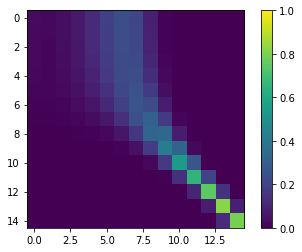

In [45]:
plt.figure()
plt.imshow(pix_mkk, vmax = 1, vmin = 0)
plt.colorbar()
plt.savefig('plots/pixel_mode_coupling_mkk_beam', dpi = 200)